In [68]:
#FN score he got was around 90% in macro, more then 80
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot

# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_validate

# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#heatmap
import seaborn as sns

#multiclass imports
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier #Will identify the maority calss base line, model needs to do better then the baseline

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

# to reduce randomness then you put the seed
np.random.seed(42)

In [63]:
df = pd.read_csv("./data/student_prediction.csv")

df = df.rename(columns = {'KIDS':'PARENT_STATUS'}) #There is a column name error in the data noted in the Kaggle description, this fixes it.
df = df.drop(["STUDENTID", "COURSE ID"], axis=1)

gathered_df = pd.read_csv("./data/Higher Education Students Performance Evaluation.csv")
gathered_df = gathered_df.rename(columns = {'KIDS':'PARENT_STATUS'})
res = list(set(df).difference(set(gathered_df)))
print(res)
#df = pd.concat([df, gathered_df], axis=0)
print(f"Data shape: \n{df.shape}\n")
print(f"Data size: \n{df.size}\n")
print(f"Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")



[]
Data shape: 
(145, 31)

Data size: 
4495

Data ndim: 
2

_____________________________________________



<AxesSubplot:>

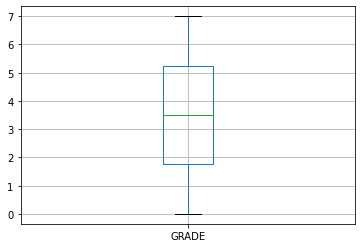

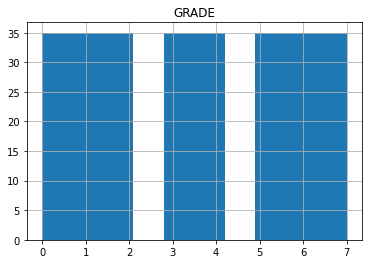

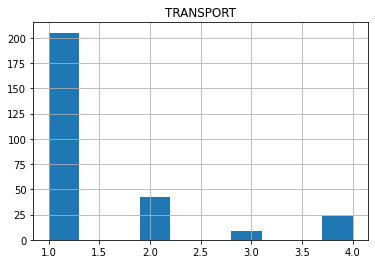

Error in callback <function flush_figures at 0x121845ee0> (for post_execute):


In [69]:
boxplot = df.boxplot(column = 'GRADE')
histogram = df.hist(column = 'GRADE')
histogram = df.hist(column = 'TRANSPORT')
scatterPlot = df.plot.scatter(x='GENDER', y='GRADE', c='orange')
scatterPlot.xaxis.label.set_color('white')        #setting up X-axis label color to white
scatterPlot.yaxis.label.set_color('white')          #setting up Y-axis label color to white
scatterPlot.tick_params(axis='x', colors='white')    #setting up X-axis tick color to white
scatterPlot.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to white
scatterPlot.spines['left'].set_color('white')        # setting up Y-axis tick color to white
scatterPlot.spines['top'].set_color('white')         #setting up above X-axis tick color to white
scatterPlot
sns.heatmap(df, annot=True)

In [65]:
oversample = SMOTE()
x_over, y_over = oversample.fit_resample(df.drop(["GRADE"], axis=1), df.drop(df.columns[0:-1],axis=1))
df = pd.concat([x_over, y_over], axis=1)

# print the dimensionality of the oversampled training dataset (0.5)
print(f"Oversampled Data shape: \n{df.shape}\n")
print(f"Oversampled Data size: \n{df.size}\n")
print(f"Oversampled Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")


# print the new class distribution using the Counter (1)
print(f"New Class Distribution: {Counter(df['GRADE'])}")
print("_____________________________________________\n")

Oversampled Data shape: 
(280, 31)

Oversampled Data size: 
8680

Oversampled Data ndim: 
2

_____________________________________________

New Class Distribution: Counter({1: 35, 2: 35, 5: 35, 0: 35, 3: 35, 4: 35, 7: 35, 6: 35})
_____________________________________________



<AxesSubplot:xlabel='GENDER', ylabel='GRADE'>

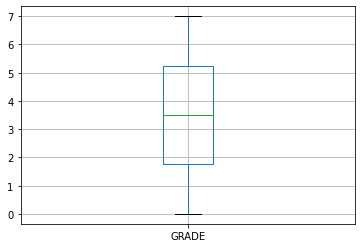

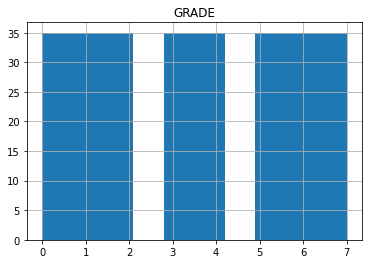

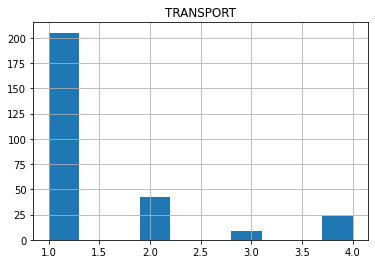

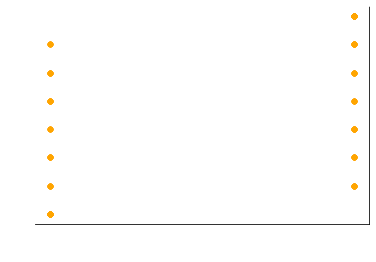

In [66]:
#how oversampling changes our data
boxplot = df.boxplot(column = 'GRADE')
histogram = df.hist(column = 'GRADE')
histogram = df.hist(column = 'TRANSPORT')
scatterPlot = df.plot.scatter(x='GENDER', y='GRADE', c='orange')
scatterPlot.xaxis.label.set_color('white')        #setting up X-axis label color to white
scatterPlot.yaxis.label.set_color('white')          #setting up Y-axis label color to white
scatterPlot.tick_params(axis='x', colors='white')    #setting up X-axis tick color to white
scatterPlot.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to white
scatterPlot.spines['left'].set_color('white')        # setting up Y-axis tick color to white
scatterPlot.spines['top'].set_color('white')         #setting up above X-axis tick color to white
scatterPlot

In [57]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train Data shape: \n{data_train}\n")
print(f"Test Data shape: \n{data_test}\n")

Train Data shape: 
     AGE  GENDER  HS_TYPE  SCHOLARSHIP  WORK  ACTIVITY  PARTNER  SALARY  \
86     2       2        2            4     2         2        2       1   
137    1       1        1            5     2         1        2       1   
184    2       2        2            4     1         2        2       1   
5      2       2        2            3     2         2        2       2   
124    1       1        2            4     1         1        1       1   
..   ...     ...      ...          ...   ...       ...      ...     ...   
188    1       2        2            3     1         2        1       4   
71     1       1        3            4     2         2        2       1   
106    1       2        2            4     2         1        2       1   
270    1       2        2            4     2         1        1       1   
102    1       2        2            3     2         2        1       1   

     TRANSPORT  LIVING  ...  ATTEND  PREP_STUDY  PREP_EXAM  NOTES  LISTENS  \
86

In [58]:
df

,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,LIVING,...,ATTEND,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,GRADE
0,2,2,3,3,1,2,2,1,1,1,...,1,1,1,3,2,1,2,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,1,3,2,3,2,2,3,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,1,2,2,1,1,2,2,1
3,1,1,1,3,1,2,1,2,1,2,...,1,1,2,3,2,2,1,3,2,1
4,2,2,1,3,2,2,1,3,1,4,...,1,2,1,2,2,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,1,2,2,4,1,2,1,1,1,1,...,1,1,1,3,2,2,2,3,3,7
276,1,2,2,4,2,1,1,1,1,2,...,1,1,1,3,2,2,1,2,3,7
277,1,2,1,2,2,2,1,2,1,2,...,1,2,1,2,2,2,1,1,1,7
278,1,2,2,4,2,1,1,1,1,1,...,1,1,1,3,2,3,2,2,3,7


In [59]:
#Extracting Labels

columns = data_train.columns.to_list()
columns_drop = columns.pop(-1)
labels_train = data_train.drop(columns, axis=1)
labels_test = data_test.drop(columns, axis=1)

print(f"labels_train: \n{labels_train}\n")
print(f"labels_test: \n{labels_test}\n")

features_train = data_train.drop(['GRADE'], axis=1)
features_test = data_test.drop(['GRADE'], axis=1)
print(f"features_train: \n{features_train }\n")
print(f"lfeatures_test: \n{features_test }\n")



labels_train: 
     GRADE
86       5
137      2
184      3
5        2
124      3
..     ...
188      3
71       6
106      7
270      7
102      7

[224 rows x 1 columns]

labels_test: 
     GRADE
33       2
108      6
240      6
259      6
154      0
9        0
146      0
203      4
144      3
155      0
221      4
92       7
222      5
209      4
42       1
210      4
66       5
90       6
119      2
142      1
262      7
268      7
206      4
238      5
46       5
77       7
68       5
75       7
216      4
277      7
45       3
111      2
60       2
217      4
143      4
30       5
22       3
24       2
127      1
176      2
79       3
264      7
237      5
120      1
196      3
245      6
168      0
6        5
239      5
73       6
84       7
56       5
25       3
97       6
147      0
19       3

features_train: 
     AGE  GENDER  HS_TYPE  SCHOLARSHIP  WORK  ACTIVITY  PARTNER  SALARY  \
86     2       2        2            4     2         2        2       1   
137    1       1   

In [60]:

ohenc = OneHotEncoder(sparse=False)

ohenc_cols = ohenc.fit(features_train.drop(['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA'], axis=1)).get_feature_names_out()


ord_attribs = ['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA']
nom_attribs = ['GENDER', 'HS_TYPE', 'WORK', 'ACTIVITY', 'PARTNER', 'TRANSPORT', 'LIVING', 'PARENT_STATUS',
                'MOTHER_JOB', 'FATHER_JOB', 'ATTEND_DEPT', 'PREP_STUDY', 'PREP_EXAM', 'CLASSROOM']

pipe_cols = ['AGE' ,'GENDER_1' ,'GENDER_2' ,'HS_TYPE_1' ,'HS_TYPE_2' ,'HS_TYPE_3', 'SCHOLARSHIP' ,'WORK_1',
             'WORK_2' ,'ACTIVITY_1', 'ACTIVITY_2', 'PARTNER_1' ,'PARTNER_2' ,'SALARY', 'TRANSPORT_1',
             'TRANSPORT_2', 'TRANSPORT_3' ,'TRANSPORT_4' ,'LIVING_1' ,'LIVING_2', 'LIVING_3', 'LIVING_4',
             'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'PARENT_STATUS_1' ,'PARENT_STATUS_2', 'PARENT_STATUS_3',
             'MOTHER_JOB_1' ,'MOTHER_JOB_2' ,'MOTHER_JOB_3', 'MOTHER_JOB_4' ,'MOTHER_JOB_5' ,'FATHER_JOB_1' , 
             'FATHER_JOB_2', 'FATHER_JOB_3' ,'FATHER_JOB_4' ,'FATHER_JOB_5', 'STUDY_HRS', 'READ_FREQ',
             'READ_FREQ_SCI',  'ATTEND_DEPT_1', 'ATTEND_DEPT_2', 'IMPACT', 'ATTEND','PREP_STUDY_1' ,'PREP_STUDY_2', 
             'PREP_STUDY_3', 'PREP_EXAM_1', 'PREP_EXAM_2' ,'PREP_EXAM_3' ,'NOTES', 'LISTENS', 'LIKES_DISCUSS', 
             'CLASSROOM_1' ,'CLASSROOM_2', 'CLASSROOM_3','CUML_GPA', 'EXP_GPA']

full_pipeline = ColumnTransformer([
        ("Nominal", OneHotEncoder(), nom_attribs),
        ("Ordinal", OrdinalEncoder(), ord_attribs)
    ])

data_prepared = pd.DataFrame(full_pipeline.fit_transform(features_train),columns=pipe_cols, index=features_train.index)
#full_pipeline.fit_transform(data_train)
#pd.DataFrame(full_pipeline.fit_transform(train_df),columns=train_df.columns, index=train_df.index)\

zero_data = np.zeros(shape=(len(data_prepared),1))

#data_prepared.insert(37,"MOTHER_EDU_6", zero_data) #Inserting those columns that are not represented in the train data



In [61]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)
labelTrainFlat = labels_train.values.ravel()
# Gradient Boosting
gradientBoosting = OneVsRestClassifier(GradientBoostingClassifier())
gradientBoosting = gradientBoosting.fit(data_prepared, labelTrainFlat)

# Decision Trees
decisionTree = DecisionTreeClassifier()
decisionTree = decisionTree.fit(data_prepared,labelTrainFlat)

# Random Forests
randomForest = RandomForestClassifier()
randomForest = randomForest.fit(data_prepared,labelTrainFlat)

In [62]:
parametersGradientBoosting = [
    {'estimator__learning_rate': [0.44,0.45,0.46],'estimator__min_samples_leaf': [5,6,7],'estimator__min_samples_split': [7,8,9,10], 'estimator__n_estimators': [57,58,59,60]}
]
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

grid_searchGradientBoosting = GridSearchCV(gradientBoosting, parametersGradientBoosting, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchGradientBoosting.fit(data_prepared, labelTrainFlat)

print(f"Best parameters GradientBoosting: \n{grid_searchGradientBoosting.best_params_}\n")
print(f"Best estimator GradientBoosting: \n{grid_searchGradientBoosting.best_estimator_}\n")
print(f"Best score GradientBoosting: \n{grid_searchGradientBoosting.best_score_}\n")

Best parameters GradientBoosting: 
{'estimator__learning_rate': 0.46, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 7, 'estimator__n_estimators': 60}

Best estimator GradientBoosting: 
OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.46,
                                                         min_samples_leaf=5,
                                                         min_samples_split=7,
                                                         n_estimators=60))

Best score GradientBoosting: 
0.6821056547619048



In [63]:

# KNeighbors
kNeighbors = KNeighborsClassifier()
kNeighbors = kNeighbors.fit(data_prepared,labelTrainFlat)

parametersKNeighbors = [
    {'n_neighbors': [1,2,3],'weights':['uniform', 'distance'],'algorithm':['auto'], 'p': [1,2,3]}
]
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

grid_searchKNeighbors = GridSearchCV(kNeighbors, parametersKNeighbors, cv=3, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchKNeighbors.fit(data_prepared, labelTrainFlat)

print(f"Best parameters KNeighbors: \n{grid_searchKNeighbors.best_params_}\n")
print(f"Best estimator KNeighbors: \n{grid_searchKNeighbors.best_estimator_}\n")
print(f"Best score KNeighbors: \n{grid_searchKNeighbors.best_score_}\n")

Best parameters KNeighbors: 
{'algorithm': 'auto', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

Best estimator KNeighbors: 
KNeighborsClassifier(n_neighbors=2, weights='distance')

Best score KNeighbors: 
0.6709701178451177



In [64]:
# LogisticRegression
logisticRegression = LogisticRegression()
logisticRegression = logisticRegression.fit(data_prepared,labelTrainFlat)

parametersLogisticRegression = [
    {'multi_class': ['ovr'],'penalty':['none','l2'], 'C': [1,2,3]}
]
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

grid_searchLogisticRegression = GridSearchCV(logisticRegression, parametersLogisticRegression, cv=3, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchLogisticRegression.fit(data_prepared, labelTrainFlat)

print(f"Best parameters Logistic Regression: \n{grid_searchLogisticRegression.best_params_}\n")
print(f"Best estimator Logistic Regression: \n{grid_searchLogisticRegression.best_estimator_}\n")
print(f"Best score Logistic Regression: \n{grid_searchLogisticRegression.best_score_}\n")

C:\Users\adamj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\adamj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best parameters Logistic Regression: 
{'C': 2, 'multi_class': 'ovr', 'penalty': 'l2'}

Best estimator Logistic Regression: 
LogisticRegression(C=2, multi_class='ovr')

Best score Logistic Regression: 
0.5035563973063972



In [65]:
parametersDecisionTree = [
    {'max_depth': [1,2,3,4], 'min_samples_leaf': [4,5,6], 'min_samples_split': [1,2,3]}
]

grid_searchDecisionTree = GridSearchCV(decisionTree, parametersDecisionTree, cv=3, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchDecisionTree.fit(data_prepared, labelTrainFlat)

print(f"Best parameters DecisionTree: \n{grid_searchDecisionTree.best_params_}\n")
print(f"Best estimator DecisionTree: \n{grid_searchDecisionTree.best_estimator_}\n")
print(f"Best score DecisionTree: \n{grid_searchDecisionTree.best_score_}\n")

Best parameters DecisionTree: 
{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}

Best estimator DecisionTree: 
DecisionTreeClassifier(max_depth=4, min_samples_leaf=4)

Best score DecisionTree: 
0.33188131313131314



C:\Users\adamj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\adamj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adamj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\adamj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py",

In [66]:
parametersRandomForest = [
    {'n_estimators': [145,150,155,190],'max_depth': [10,12], 'bootstrap': [True, False],
     'min_samples_split': [0.05,2]}
]

grid_searchRandomForest = GridSearchCV(randomForest, parametersRandomForest, cv=4, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchRandomForest.fit(data_prepared, labelTrainFlat)

print(f"Best parameters RandomForest: \n{grid_searchRandomForest.best_params_}\n")

print(f"Best estimator RandomForest: \n{grid_searchRandomForest.best_estimator_}\n")

print(f"Best score RandomForest: \n{grid_searchRandomForest.best_score_}\n")

Best parameters RandomForest: 
{'bootstrap': False, 'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 150}

Best estimator RandomForest: 
RandomForestClassifier(bootstrap=False, max_depth=12, n_estimators=150)

Best score RandomForest: 
0.6945684523809523



In [67]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
cross_val_resultsGB = grid_searchGradientBoosting.cv_results_
cross_val_resultsDT = grid_searchDecisionTree.cv_results_
cross_val_resultsRF = grid_searchRandomForest.cv_results_



print(f"Mean Test Accuracy for GradientBoosting: \n{cross_val_resultsGB['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for GradientBoosting: \n{cross_val_resultsGB['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for GradientBoosting: \n{cross_val_resultsGB['mean_test_F1_macro']}\n")

#DTC
print(f"Mean Test Accuracy for Decision Trees: \n{cross_val_resultsDT['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for Decision Trees: \n{cross_val_resultsDT['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for Decision Trees: \n{cross_val_resultsDT['mean_test_F1_macro']}\n")

#RFC
print(f"Mean Test Accuracy for Random Forests: \n{cross_val_resultsRF['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for Random Forests: \n{cross_val_resultsRF['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for Random Forests: \n{cross_val_resultsRF['mean_test_F1_macro']}\n")

#NB


Mean Test Accuracy for GradientBoosting: 
[0.66517857 0.65625    0.64732143 0.65625    0.66517857 0.64732143
 0.65178571 0.65178571 0.67857143 0.66071429 0.65625    0.65178571
 0.65625    0.64732143 0.65178571 0.66517857 0.65625    0.65625
 0.64732143 0.64732143 0.64732143 0.65625    0.65178571 0.65625
 0.66071429 0.65625    0.64732143 0.65178571 0.66071429 0.65625
 0.65178571 0.65625    0.62946429 0.625      0.63839286 0.62946429
 0.63392857 0.61160714 0.63392857 0.64732143 0.625      0.62946429
 0.65178571 0.63839286 0.64285714 0.62946429 0.63392857 0.65178571
 0.64732143 0.65625    0.66517857 0.65625    0.66517857 0.65625
 0.64285714 0.66071429 0.65178571 0.65625    0.65625    0.65625
 0.64732143 0.65178571 0.65178571 0.65178571 0.65178571 0.63839286
 0.64285714 0.64732143 0.65178571 0.63392857 0.63392857 0.63839286
 0.65178571 0.63839286 0.63839286 0.63839286 0.64732143 0.63392857
 0.64285714 0.63839286 0.65178571 0.63839286 0.63839286 0.63839286
 0.63392857 0.64285714 0.63392857 0

In [68]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results (3)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(data_prepared, labelTrainFlat)
DummyClassifier(strategy='most_frequent')
print(f"Dummy Prediction: \n{dummy_clf.predict(data_prepared)}\n") 
print(f"Dummy Score: \n{dummy_clf.score(data_prepared, labelTrainFlat)}\n") 

Dummy Prediction: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]

Dummy Score: 
0.13839285714285715



In [72]:

ohenc_test = OneHotEncoder(sparse=False)
ohenc_cols_test = ohenc.fit(features_test.drop(['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA'], axis=1)).get_feature_names_out()




missing_cols_from_test = ['MOTHER_JOB_5', 'LIVING_4', 'FATHER_EDU_6']
missing_cols_from_train = ['MOTHER_EDU_6']

ord_attribs_test = ['AGE', 'SCHOLARSHIP', 'SALARY', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'STUDY_HRS', 
                'READ_FREQ', 'READ_FREQ_SCI', 'IMPACT', 'ATTEND', 'NOTES', 'LISTENS', 'LIKES_DISCUSS',
                'CUML_GPA', 'EXP_GPA']
nom_attribs_test = ['GENDER', 'HS_TYPE', 'WORK', 'ACTIVITY', 'PARTNER', 'TRANSPORT', 'LIVING', 'PARENT_STATUS',
                'MOTHER_JOB', 'FATHER_JOB', 'ATTEND_DEPT', 'PREP_STUDY', 'PREP_EXAM', 'CLASSROOM']

pipe_cols_test = ['AGE' ,'GENDER_1' ,'GENDER_2' ,'HS_TYPE_1' ,'HS_TYPE_2' ,'HS_TYPE_3', 'SCHOLARSHIP' ,'WORK_1',
             'WORK_2' ,'ACTIVITY_1', 'ACTIVITY_2', 'PARTNER_1' ,'PARTNER_2' ,'SALARY', 'TRANSPORT_1',
             'TRANSPORT_2', 'TRANSPORT_3' ,'TRANSPORT_4' ,'LIVING_1' ,'LIVING_2', 'LIVING_3',
             'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'PARENT_STATUS_1' ,'PARENT_STATUS_2', 'PARENT_STATUS_3',
             'MOTHER_JOB_1' ,'MOTHER_JOB_2' ,'MOTHER_JOB_3', 'MOTHER_JOB_4' ,'FATHER_JOB_1' , 
             'FATHER_JOB_2', 'FATHER_JOB_3' ,'FATHER_JOB_4' ,'FATHER_JOB_5', 'STUDY_HRS', 'READ_FREQ',
             'READ_FREQ_SCI',  'ATTEND_DEPT_1', 'ATTEND_DEPT_2', 'IMPACT', 'ATTEND','PREP_STUDY_1' ,'PREP_STUDY_2', 
             'PREP_STUDY_3', 'PREP_EXAM_1', 'PREP_EXAM_2' ,'PREP_EXAM_3' ,'NOTES', 'LISTENS', 'LIKES_DISCUSS', 
             'CLASSROOM_1' ,'CLASSROOM_2', 'CLASSROOM_3','CUML_GPA', 'EXP_GPA']


full_pipeline_test = ColumnTransformer([
        ("Nominal", OneHotEncoder(), nom_attribs),
        ("Ordinal", OrdinalEncoder(), ord_attribs)
    ])



data_prepared_test = pd.DataFrame(full_pipeline_test.fit_transform(features_test),columns=pipe_cols_test, index=features_test.index)
missing_cols_df = pd.DataFrame(0, index=np.arange(56), columns=missing_cols_from_test)
res = list(set(ohenc_cols).difference(set(ohenc_cols_test)))

zero_data = np.zeros(shape=(len(data_prepared_test),1))


data_prepared_test.insert(31,"MOTHER_JOB_5", zero_data) #Inserting those columns that are not represented in the test data
data_prepared_test.insert(21,"LIVING_4", zero_data)

#data_prepared_test.insert(43,"FATHER_EDU_6", zero_data)



# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
predictions_test = grid_searchRandomForest.best_estimator_.predict(data_prepared_test)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(labels_test.values.ravel(),predictions_test))
print(confusion_matrix(labels_test, predictions_test))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       0.00      0.00      0.00         4
           2       0.80      0.67      0.73         6
           3       0.71      0.71      0.71         7
           4       0.88      0.88      0.88         8
           5       0.83      0.50      0.62        10
           6       0.50      0.43      0.46         7
           7       0.86      0.75      0.80         8

    accuracy                           0.64        56
   macro avg       0.64      0.62      0.61        56
weighted avg       0.69      0.64      0.65        56

[[6 0 0 0 0 0 0 0]
 [3 0 0 0 0 0 0 1]
 [0 1 4 0 0 1 0 0]
 [0 1 1 5 0 0 0 0]
 [1 0 0 0 7 0 0 0]
 [0 2 0 0 1 5 2 0]
 [1 2 0 1 0 0 3 0]
 [0 0 0 1 0 0 1 6]]
